In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
df = pd.read_csv('dataset.csv')
df 

,id,web_URL_id,domain_category,web_URL,scrape_status,html_file_name,html_file_path,violation_count,violation_name,violation_score,violation_description,violation_description_url,affected_html_elements,violation_category,violation_impact,wcag_reference,supplementary_information
0,700_0,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/buy-from-government\"">How to buy fro...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."
1,700_1,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-banner-is-top-level,3,Ensures the banner landmark is at top level,https://dequeuniversity.com/rules/axe/4.4/land...,"<div class=\usa-banner__header\"" role=\""banner...",Syntax,moderate,['1.3.1 Info and Relationships'],"<div class=\usa-banner__header\"" role=\""banner..."
2,700_2,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-no-duplicate-banner,3,Ensures the document has at most one banner la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],11 <header> or role='banner' elements found:\n...
3,700_3,700,Government and Public Services,https://www.usa.gov/about-the-us,scraped,www_usa_gov_about_the_us.html,/content/workspace/FullPipeline/html_pages_asy...,4,landmark-unique,3,Landmarks should have a unique role or role/la...,https://dequeuniversity.com/rules/axe/4.4/land...,<header class=\usa-header usa-header--extended...,Syntax,moderate,['1.3.1 Info and Relationships'],Role 'search' found 2 times:\n<form accept-cha...
4,701_0,701,Government and Public Services,https://www.usa.gov/benefits,scraped,www_usa_gov_benefits.html,/content/workspace/FullPipeline/html_pages_asy...,4,color-contrast-enhanced,4,Ensures the contrast between foreground and ba...,https://dequeuniversity.com/rules/axe/4.4/colo...,"<a href=\/food-help\"">Learn about food assista...",Layout,serious,['1.4.6 Contrast (Enhanced)'],"{'fgColor': '#00bde3', 'bgColor': '#112f4e', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,6019,4643564980,TechnologyScienceResearch,https://dequeuniversity.com/rules/axe/4.10/ari...,scraped,4643564980.txt,/Volumes/MacPema/HIWI/WebAccessibility-main/20...,1,aria-braille-equivalent,4,Ensure aria-braillelabel and aria-brailleroled...,https://dequeuniversity.com/rules/axe/4.10/ari...,"<img alt=\\"" aria-braillelabel=\""****\"" src=\""...",NaN,serious,"['4.1.2 Name, Role, Value']",NaN
3520,6020,581517740,TechnologyScienceResearch,https://dequeuniversity.com/rules/axe/4.10/tar...,scraped,581517740.txt,/Volumes/MacPema/HIWI/WebAccessibility-main/20...,1,target-size,4,Ensure touch targets have sufficient size and ...,https://dequeuniversity.com/rules/axe/4.10/tar...,"<button id=\target\"">+</button>\n <button s...",Layout,serious,['2.5.5 Target Size'],NaN
3521,6021,2182179087,TechnologyScienceResearch,https://dequeuniversity.com/rules/axe/4.10/emp...,scraped,2182179087.txt,/Volumes/MacPema/HIWI/WebAccessibility-main/20...,1,empty-table-header,2,Ensure table headers have discernible text,NaN,https://dequeuniversity.com/rules/axe/4.10/emp...,Syntax,minor,"['1.3.1 Info and Relationships', '2.4.6 Headin...",NaN
3522,6022,853326546,TechnologyScienceResearch,https://dequeuniversity.com/rules/axe/4.10/ari...,scraped,853326546.txt,/Volumes/MacPema/HIWI/WebAccessibility-main/20...,1,aria-meter-name,4,Ensure every ARIA meter node has an accessible...,https://dequeuniversity.com/rules/axe/4.10/ari...,"<div role=\meter\"" id=\

In [13]:
df["domain_category"] = df["domain_category"].replace("Ecommerce", "E-commerce")
df["domain_category"] = df["domain_category"].replace("TechnologyScienceResearch", "Technology Science and Research")
df["scrape_status"].value_counts(dropna=False).head(20)


scrape_status
scraped    3524
Name: count, dtype: int64

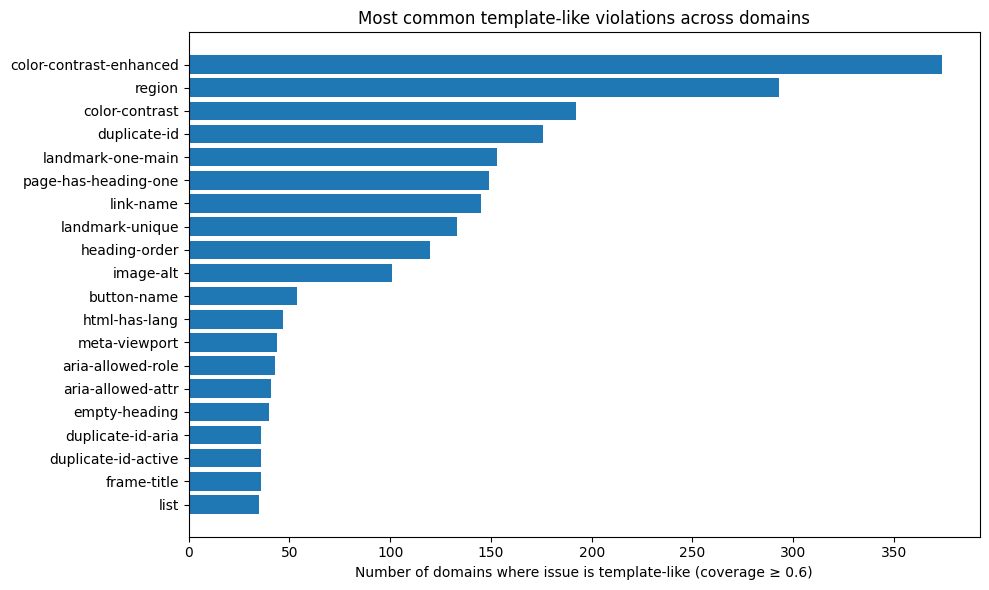

             violation_name  domains  total_pages_with_violation  \
0   color-contrast-enhanced      374                         466   
1                    region      293                         350   
2            color-contrast      192                         223   
3              duplicate-id      176                         210   
4         landmark-one-main      153                         165   
5      page-has-heading-one      149                         158   
6                 link-name      145                         182   
7           landmark-unique      133                         170   
8             heading-order      120                         139   
9                 image-alt      101                         104   
10              button-name       54                          69   
11            html-has-lang       47                          47   
12            meta-viewport       44                          44   
13        aria-allowed-role       43            

In [29]:
# Should Fix Cost Less
from urllib.parse import urlparse

# --- columns in your file ---
col_url = "web_URL"
col_id  = "web_URL_id"
col_violation = "violation_name"
col_impact = "violation_impact"
col_count = "violation_count"

# --- extract domain ---
def get_domain(u):
    p = urlparse(str(u))
    host = p.netloc.lower()
    if host.startswith("www."):
        host = host[4:]
    return host

df["domain"] = df[col_url].apply(get_domain)

# --- severity weighting ---
impact_w = {"critical":5, "serious":4, "moderate":3, "minor":2}
df["impact_w"] = df[col_impact].astype(str).str.lower().map(impact_w).fillna(1)

df["_cnt"] = pd.to_numeric(df[col_count], errors="coerce").fillna(1)

# total pages sampled per domain
pages_per_domain = df.groupby("domain")[col_id].nunique().rename("total_pages")

# pages with each violation per domain
pages_with_violation = df.groupby(["domain", col_violation])[col_id].nunique().rename("pages_with_violation")

# avg severity per (domain, violation_name), weighted by #instances
avg_sev = df.groupby(["domain", col_violation]).apply(
    lambda x: np.average(x["impact_w"], weights=x["_cnt"]) if x["_cnt"].sum() > 0 else x["impact_w"].mean()
).rename("avg_severity_w")

# final table
template = pd.concat([pages_with_violation, avg_sev], axis=1).reset_index()
template = template.merge(pages_per_domain.reset_index(), on="domain", how="left")
template["coverage"] = template["pages_with_violation"] / template["total_pages"]
template["template_like"] = template["coverage"] >= 0.6

plt.show()

# --- Viz 2: bar chart of top template-like violations across domains ---
tpl = template[template["template_like"]].copy()
top_tpl = (tpl.groupby(col_violation)
             .agg(domains=("domain","nunique"),
                  total_pages_with_violation=("pages_with_violation","sum"),
                  mean_coverage=("coverage","mean"),
                  mean_severity=("avg_severity_w","mean"))
             .sort_values(["domains","total_pages_with_violation","mean_severity"], ascending=False)
             .head(20)
             .reset_index())

plt.figure(figsize=(10,6))
plt.barh(top_tpl[col_violation][::-1], top_tpl["domains"][::-1])
plt.xlabel("Number of domains where issue is template-like (coverage ≥ 0.6)")
plt.title("Most common template-like violations across domains")
plt.tight_layout()
plt.show()

print(top_tpl)

In [26]:
# Only template-like rows (coverage >= 0.6)
tpl = template[template["template_like"]].copy()

# Pick the "most common" template violation per site:
# rule = highest pages_with_violation (ties -> higher coverage -> higher severity)
most_common_template_per_site = (
    tpl.sort_values(
        ["domain", "pages_with_violation", "coverage", "avg_severity_w"],
        ascending=[True, False, False, False]
    )
    .groupby("domain", as_index=False)
    .first()
    .rename(columns={col_violation: "most_common_template_violation"})
    [["domain", "most_common_template_violation",
      "pages_with_violation", "total_pages", "coverage", "avg_severity_w"]]
)

# nicer percent column
most_common_template_per_site["coverage_pct"] = (most_common_template_per_site["coverage"] * 100).round(1)

print(most_common_template_per_site.to_string(index=False))


                     domain most_common_template_violation  pages_with_violation  total_pages  coverage  avg_severity_w  coverage_pct
                 3dcart.com              aria-allowed-attr                     1            1       1.0             5.0         100.0
                 abc.net.au              duplicate-id-aria                     1            1       1.0             5.0         100.0
             abcnews.go.com         aria-required-children                     1            1       1.0             5.0         100.0
               academia.edu                      image-alt                     1            1       1.0             5.0         100.0
          academicearth.org                 color-contrast                     1            1       1.0             4.0         100.0
             acefitness.org              aria-allowed-attr                     1            1       1.0             5.0         100.0
                acf.hhs.gov                  html-has-lang    